# Autoencoder trained on the preprocessed dataset.
-------------------------------------------------------------------------------------------------------------------
# Technology used: Tensorflow 

### Changes: mostly same as the old one, with a diferent batch size for training along with tensorboard summary inclusion

### Changes over previous: Trying to debug the batch normalization error

### Start with creating some utility cells

In [7]:
# packages used for processing: 
import matplotlib.pyplot as plt # for visualization
import numpy as np

# deep learning framework
import tensorflow as tf

# for operating system related stuff
import os
import sys # for memory usage of objects
from subprocess import check_output

# to plot the images inline
%matplotlib inline

In [2]:
# Input data files are available in the "../Data/" directory.

def exec_command(cmd):
    '''
        function to execute a shell command and see it's 
        output in the python console
        @params
        cmd = the command to be executed along with the arguments
              ex: ['ls', '../input']
    '''
    print(check_output(cmd).decode("utf8"))

In [3]:
# check the structure of the project directory
exec_command(['ls', '..'])

LICENSE
Models
network_architecture
processed_words_binary_data
README.md
readme.txt
readme.txt~
Scripts
svc2004
task_log
thresh_wordnet_english_test.py
thresh_wordnet_english_test.py~
words_binary



In [4]:
# ''' Set the constants for the script '''

# various paths of the files
data_path = "../words_binary" # the data path
base_model_path = "../Models"
processed_data_path = "../processed_words_binary_data"
log_dir = os.path.join(base_model_path, "logdir")

# constants for the preprocessing script
data_size = (96, 192, 3)
batch_size = 5000 # 10000 images in each batch
no_of_epochs = 200 # run the training loop for 200 epochs
no_of_batches = 10 # There are 10 batches of data
checkpoint_factor = 2 # save the model after every 2 epochs

In [5]:
# load a batch and check a few images from it
batch_path = os.path.join(processed_data_path, "batch_1")
sanity_test_batch = np.load(batch_path)

In [6]:
sanity_test_batch.shape

(5000, 96, 192, 3)

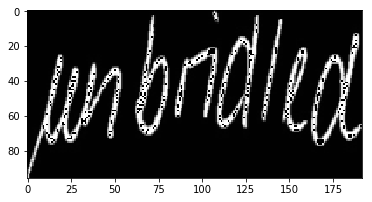

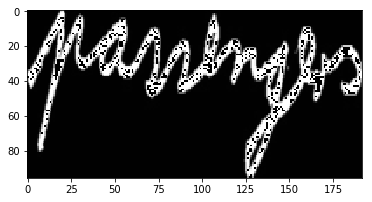

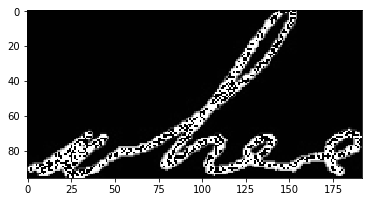

In [8]:
# display a few random images from the dataset:
for _ in range(3):
    random_index = np.random.randint(sanity_test_batch.shape[0])
    plt.figure()
    plt.imshow(sanity_test_batch[random_index])

# In the following cell, I define the computation graph for the network architecture that has been proposed for this task

There is a lot of code written in a single cell, so take a step by step approach towards understanding it

In [9]:
'''
    This cell defines the method required to spawn and return a tensorflow graph for the autoencoder model.
    coded by: Animesh
'''

import tensorflow as tf


myGraph = tf.Graph() #create a new graph object

with myGraph.as_default():
    # define the computations of this graph here:
    
    # helper functions to run the model:
    def normalize(ip_tensor, name = "normalization"):
        '''
            function to normalize the input tensor in the range of [-1, 1] 
            @param
            ip_tensor => the tensor to be normalized
            @return => the normalized version of the tensor
        '''
        with tf.name_scope(name): 
            ip_range = tf.reduce_max(ip_tensor) - tf.reduce_min(ip_tensor)
            mean = tf.reduce_mean(ip_tensor)
            return (ip_tensor - mean) / ip_range
    
    

    # placeholder for the input data batch
    inputs = tf.placeholder(dtype= tf.float32, 
                            shape=(None, data_size[0], data_size[1], data_size[2]), name="inputs")
    
    # normalized inputs to the range of [-1, 1]
    normalized_inputs = normalize(inputs, name="input_normalization")
    
    # create a summary node for some of the inputs
    inputs_summary = tf.summary.image("Input", normalized_inputs[:8])
    # visualize only first 8 images from the batch

    
    # We feed the original inputs to the convNet as shown below:
    # encoder layers: 96 x 192
    conv1_1 = tf.layers.conv2d(inputs, 32, [7, 7], strides=(2, 2), 
                            padding="SAME", name="conv_layer1_1")
    
    bn1_1 = tf.contrib.layers.batch_norm(conv1_1)
    
    # record histogram summary:
    bn1_1_summary = tf.summary.histogram("bn1_1_summary", bn1_1)
    
    relu1_1 = tf.nn.relu(bn1_1, name="relu1_1")
    
    # 48 x 96
    conv1_2 = tf.layers.conv2d(relu1_1, 32, [5, 5], strides=(2, 2),
                            padding="SAME", name="conv_layer1_2")
    
    bn1_2 = tf.contrib.layers.batch_norm(conv1_2)
    
    relu1_2 = tf.nn.relu(bn1_2, name="relu1_2")
    
    # 24 x 48
    conv1_3 = tf.layers.conv2d(relu1_2, 32, [5, 5], strides=(2, 2),
                            padding="SAME", name="conv_layer1_3")
    
    bn1_3 = tf.contrib.layers.batch_norm(conv1_3)
    
    relu1_3 = tf.nn.relu(bn1_3, name="relu1_3")
    
    # 12 x 24
    conv1_4 = tf.layers.conv2d(relu1_3, 16, [3, 3], strides=(2, 2), 
                            padding="SAME", name="conv_layer1_4")

    bn1_4 = tf.contrib.layers.batch_norm(conv1_4)
    
    # record histogram summary:
    bn1_4_summary = tf.summary.histogram("bn1_4_summary", bn1_4)
    
    relu1_4 = tf.nn.relu(bn1_4, name="relu1_4")
    
    # 6 x 12
    
    
    # decoder layers:
    # 6 x 12
    deconv1_1 = tf.layers.conv2d_transpose(relu1_4, 32, [4, 4], strides=(2, 2), 
                                           padding="SAME", name="deconv_layer_1")
    
    deBn1_1 = tf.contrib.layers.batch_norm(deconv1_1)
    # record summary to see the values
    deBn1_1_summary = tf.summary.histogram("deBn1_1_summary", deBn1_1)
    
    deRelu1_1 = tf.nn.relu(deBn1_1, name="de_relu1_1")
    
    # 12 x 24
    deconv1_2 = tf.layers.conv2d_transpose(deRelu1_1, 32, [4, 4], strides=(2, 2), 
                                           padding="SAME", name="deconv_layer_2")
    
    deBn1_2 = tf.contrib.layers.batch_norm(deconv1_2)
    
    deRelu1_2 = tf.nn.relu(deBn1_2, name="de_relu1_2")
    
    # 24 x 48
    deconv1_3 = tf.layers.conv2d_transpose(deRelu1_2, 32, [4, 4], strides=(2, 2), 
                                           padding="SAME", name="deconv_layer_3")
    
    deBn1_3 = tf.contrib.layers.batch_norm(deconv1_3)
    
    deRelu1_3 = tf.nn.relu(deBn1_3, name="de_relu1_3")
    
    # 48 x 96
    deconv1_4 = tf.layers.conv2d_transpose(deRelu1_3, 32, [4, 4], strides=(2, 2),
                                           padding="SAME", name="deconv_layer_4")
    
    deBn1_4 = tf.contrib.layers.batch_norm(deconv1_4)
    
    # record the histogram summary:
    deBn1_4_summary = tf.summary.histogram("deBn1_4_summary", deBn1_4)
    
    deRelu1_4 = tf.nn.relu(deBn1_4, name="de_relu1_4")

    # 96 x 192
    deconv1_5 = tf.layers.conv2d_transpose(deRelu1_4, 3, [3, 3], strides=(1, 1),
                                           padding="SAME", name="deconv_layer_5")
    
    # normalize the predictions i.e deconv1_5 as mentioned above. and then use it for calculating the loss
    normalized_outputs = normalize(deconv1_5, name="output_normalization")
    
    # summary for the output image.
    output_image_summary = tf.summary.image("Output", normalized_outputs[:8]) # record corresponding outputs 
    # for the images.
    
    output = relu1_4 # get a hook on to the latent representation of the encoder
    
    # also generate the summary of the latent representations.
    output_summary = tf.summary.histogram("Latent_Representation", output)

    y_pred = normalized_outputs # output of the decoder
    y_true = normalized_inputs # input at the beginning

    # define the loss for this model:
    # calculate the loss and optimize the network
    loss = tf.norm(y_pred - y_true, ord="euclidean", name="eucledian_loss") # claculate the euclidean loss.
    
    # add a summary op for loss.
    loss_summary = tf.summary.scalar("Loss", loss)

    # using Adam optimizer for optimization
    train_op = tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0.9, beta2=0.999).minimize(loss, name="train_op")
    
    # single op to generate all the summary data
    all_summaries = tf.summary.merge_all()

In [10]:
itera = 1
model_name = "Model3"

In [11]:
# generate a graph of the above model and visualize it.
log_path = os.path.join(log_dir, model_name)
tensorboard_writer = tf.summary.FileWriter(log_path, graph=myGraph)

In [ ]:
''' 
    WARNING WARNING WARNING!!! This is the main training cell. Since, the data used for this task is SVC2004, 
    This cell will take a really really long time on low-end machines. It will however not crash your pc, since 
    I have bootstrapped the training in such a way that it loads a small chunk of data at a time to train.
'''

with tf.Session(graph=myGraph) as sess:
    
    # the path where the model will be saved 
    ''' Currently using the Model no. 3 '''
    model_path = os.path.join(base_model_path, model_name)
    
    # The saver object for saving and loading the model
    saver = tf.train.Saver(max_to_keep=2)
    
    if(os.path.isfile(os.path.join(model_path, "checkpoint"))):
        # load the weights from the model
        # instead of global variable initializer, restore the graph:
        saver.restore(sess, tf.train.latest_checkpoint(model_path))
        
    else:
        
        # initialize all the variables
        sess.run(tf.global_variables_initializer())
    
    for ep in range(46, itera * no_of_epochs):  # start the loop 
        
        print "epoch: " + str(ep + 1)
        print "================================================================================================="
        print "================================================================================================="
        
        for batch_n in range(no_of_batches):  # batches loop
            # log a comment related to the current batch:
            print "current_batch: " + str(batch_n + 1)
            
            # generate the batch images and labels
            batch_images = np.load(os.path.join(processed_data_path, "batch_" + str(batch_n + 1)))
            
            min_batch_size = 64 # we look at only 64 images in a single batch
            
            for index in range(int(float(len(batch_images)) / min_batch_size + 0.5)):
                start = index * min_batch_size
                end = start + min_batch_size
                _, cost = sess.run([train_op, loss], feed_dict={inputs: batch_images[start: end]})
                print('range:{} loss= {}'.format((start, start + len(batch_images[start:end])), cost))
                    
            print "\n=========================================================================================\n"
        
        if((ep + 1) % checkpoint_factor == 0):
            # run the summary op also
            summary = sess.run(all_summaries, feed_dict={inputs: batch_images[start: end]})

            # add the generated summary to the fileWriter
            tensorboard_writer.add_summary(summary, (ep + 1))
            
            # save the model trained so far:
            saver.save(sess, os.path.join(model_path, model_name), global_step = (ep + 1))
        
    print "================================================================================================="
    print "================================================================================================="

INFO:tensorflow:Restoring parameters from ../Models/Model3/Model3-46
epoch: 47
current_batch: 1
range:(0, 64) loss= 112.040657043
range:(64, 128) loss= 108.358467102
range:(128, 192) loss= 107.17276001
range:(192, 256) loss= 103.152641296
range:(256, 320) loss= 109.311073303
range:(320, 384) loss= 106.278808594
range:(384, 448) loss= 109.194221497
range:(448, 512) loss= 106.321212769
range:(512, 576) loss= 110.920547485
range:(576, 640) loss= 114.141082764
range:(640, 704) loss= 102.556442261
range:(704, 768) loss= 105.501876831
range:(768, 832) loss= 110.785575867
range:(832, 896) loss= 108.102615356
range:(896, 960) loss= 108.69834137
range:(960, 1024) loss= 107.138671875
range:(1024, 1088) loss= 106.007362366
range:(1088, 1152) loss= 105.998161316
range:(1152, 1216) loss= 115.026161194
range:(1216, 1280) loss= 112.568649292
range:(1280, 1344) loss= 106.402671814
range:(1344, 1408) loss= 109.899795532
range:(1408, 1472) loss= 104.979370117
range:(1472, 1536) loss= 109.62146759
range:

range:(2880, 2944) loss= 112.731712341
range:(2944, 3008) loss= 104.912452698
range:(3008, 3072) loss= 112.87512207
range:(3072, 3136) loss= 107.465270996
range:(3136, 3200) loss= 107.204040527
range:(3200, 3264) loss= 105.043144226
range:(3264, 3328) loss= 107.002120972
range:(3328, 3392) loss= 105.412757874
range:(3392, 3456) loss= 107.258270264
range:(3456, 3520) loss= 106.124252319
range:(3520, 3584) loss= 115.070022583
range:(3584, 3648) loss= 104.53591156
range:(3648, 3712) loss= 110.425094604
range:(3712, 3776) loss= 109.63986969
range:(3776, 3840) loss= 106.599777222
range:(3840, 3904) loss= 108.549545288
range:(3904, 3968) loss= 108.658180237
range:(3968, 4032) loss= 107.900352478
range:(4032, 4096) loss= 111.453125
range:(4096, 4160) loss= 107.502250671
range:(4160, 4224) loss= 107.874641418
range:(4224, 4288) loss= 107.033454895
range:(4288, 4352) loss= 108.67464447
range:(4352, 4416) loss= 103.082588196
range:(4416, 4480) loss= 103.145591736
range:(4480, 4544) loss= 107.576

range:(1024, 1088) loss= 105.05544281
range:(1088, 1152) loss= 111.559890747
range:(1152, 1216) loss= 107.627540588
range:(1216, 1280) loss= 105.518356323
range:(1280, 1344) loss= 114.039009094
range:(1344, 1408) loss= 106.456680298
range:(1408, 1472) loss= 109.480918884
range:(1472, 1536) loss= 106.16104126
range:(1536, 1600) loss= 104.249313354
range:(1600, 1664) loss= 109.168060303
range:(1664, 1728) loss= 111.557258606
range:(1728, 1792) loss= 113.204956055
range:(1792, 1856) loss= 106.810279846
range:(1856, 1920) loss= 108.697097778
range:(1920, 1984) loss= 108.828544617
range:(1984, 2048) loss= 110.390090942
range:(2048, 2112) loss= 111.010314941
range:(2112, 2176) loss= 107.031776428
range:(2176, 2240) loss= 106.290565491
range:(2240, 2304) loss= 112.026679993
range:(2304, 2368) loss= 110.735771179
range:(2368, 2432) loss= 114.651435852
range:(2432, 2496) loss= 106.876159668
range:(2496, 2560) loss= 104.663566589
range:(2560, 2624) loss= 109.472801208
range:(2624, 2688) loss= 10

range:(4288, 4352) loss= 110.296401978
range:(4352, 4416) loss= 109.167686462
range:(4416, 4480) loss= 110.810874939
range:(4480, 4544) loss= 104.906616211
range:(4544, 4608) loss= 107.156921387
range:(4608, 4672) loss= 109.494911194
range:(4672, 4736) loss= 107.509971619
range:(4736, 4800) loss= 107.55493927
range:(4800, 4864) loss= 106.141082764
range:(4864, 4928) loss= 102.412635803
range:(4928, 4992) loss= 108.734069824


current_batch: 9
range:(0, 64) loss= 108.385765076
range:(64, 128) loss= 106.534851074
range:(128, 192) loss= 111.400917053
range:(192, 256) loss= 107.325309753
range:(256, 320) loss= 108.251335144
range:(320, 384) loss= 107.651519775
range:(384, 448) loss= 109.612686157
range:(448, 512) loss= 106.738502502
range:(512, 576) loss= 107.964782715
range:(576, 640) loss= 112.299667358
range:(640, 704) loss= 119.752883911
range:(704, 768) loss= 104.22000885
range:(768, 832) loss= 110.414375305
range:(832, 896) loss= 104.582191467
range:(896, 960) loss= 109.048522949
ran

range:(3200, 3264) loss= 111.409599304
range:(3264, 3328) loss= 111.582893372
range:(3328, 3392) loss= 106.452934265
range:(3392, 3456) loss= 114.524032593
range:(3456, 3520) loss= 110.010437012
range:(3520, 3584) loss= 107.432785034
range:(3584, 3648) loss= 109.17464447
range:(3648, 3712) loss= 105.764801025
range:(3712, 3776) loss= 108.701751709
range:(3776, 3840) loss= 107.868507385
range:(3840, 3904) loss= 106.576591492
range:(3904, 3968) loss= 111.111862183
range:(3968, 4032) loss= 107.369377136
range:(4032, 4096) loss= 108.909614563
range:(4096, 4160) loss= 105.045021057
range:(4160, 4224) loss= 105.917907715
range:(4224, 4288) loss= 108.245384216
range:(4288, 4352) loss= 112.334793091
range:(4352, 4416) loss= 107.042434692
range:(4416, 4480) loss= 109.046287537
range:(4480, 4544) loss= 108.601242065
range:(4544, 4608) loss= 108.702278137
range:(4608, 4672) loss= 108.888237
range:(4672, 4736) loss= 108.12902832
range:(4736, 4800) loss= 112.036331177
range:(4800, 4864) loss= 114.8

range:(1344, 1408) loss= 107.102531433
range:(1408, 1472) loss= 110.366836548
range:(1472, 1536) loss= 106.754325867
range:(1536, 1600) loss= 113.380462646
range:(1600, 1664) loss= 108.889175415
range:(1664, 1728) loss= 112.357063293
range:(1728, 1792) loss= 103.455215454
range:(1792, 1856) loss= 116.131477356
range:(1856, 1920) loss= 105.70501709
range:(1920, 1984) loss= 116.132019043
range:(1984, 2048) loss= 105.01839447
range:(2048, 2112) loss= 106.022735596
range:(2112, 2176) loss= 107.682220459
range:(2176, 2240) loss= 112.771842957
range:(2240, 2304) loss= 107.002426147
range:(2304, 2368) loss= 111.521026611
range:(2368, 2432) loss= 110.885215759
range:(2432, 2496) loss= 107.27192688
range:(2496, 2560) loss= 104.615516663
range:(2560, 2624) loss= 102.523460388
range:(2624, 2688) loss= 111.888946533
range:(2688, 2752) loss= 108.505020142
range:(2752, 2816) loss= 107.429466248
range:(2816, 2880) loss= 107.785568237
range:(2880, 2944) loss= 106.056892395
range:(2944, 3008) loss= 106

range:(4608, 4672) loss= 104.622261047
range:(4672, 4736) loss= 105.665046692
range:(4736, 4800) loss= 110.357421875
range:(4800, 4864) loss= 109.609870911
range:(4864, 4928) loss= 104.932853699
range:(4928, 4992) loss= 114.137435913


current_batch: 7
range:(0, 64) loss= 106.758529663
range:(64, 128) loss= 108.765411377
range:(128, 192) loss= 104.396209717
range:(192, 256) loss= 109.605705261
range:(256, 320) loss= 108.402397156
range:(320, 384) loss= 114.284080505
range:(384, 448) loss= 110.636161804
range:(448, 512) loss= 107.516052246
range:(512, 576) loss= 109.276100159
range:(576, 640) loss= 105.876609802
range:(640, 704) loss= 109.142623901
range:(704, 768) loss= 104.661407471
range:(768, 832) loss= 108.457054138
range:(832, 896) loss= 108.268669128
range:(896, 960) loss= 105.761405945
range:(960, 1024) loss= 106.293319702
range:(1024, 1088) loss= 109.227142334
range:(1088, 1152) loss= 103.206741333
range:(1152, 1216) loss= 110.549987793
range:(1216, 1280) loss= 107.479278564
ra

range:(2752, 2816) loss= 105.297622681
range:(2816, 2880) loss= 110.673744202
range:(2880, 2944) loss= 110.303085327
range:(2944, 3008) loss= 106.007713318
range:(3008, 3072) loss= 117.960258484
range:(3072, 3136) loss= 109.196052551
range:(3136, 3200) loss= 109.039703369
range:(3200, 3264) loss= 115.843154907
range:(3264, 3328) loss= 108.26247406
range:(3328, 3392) loss= 104.243019104
range:(3392, 3456) loss= 110.890167236
range:(3456, 3520) loss= 108.319137573
range:(3520, 3584) loss= 108.442062378
range:(3584, 3648) loss= 105.124359131
range:(3648, 3712) loss= 109.058799744
range:(3712, 3776) loss= 104.965415955
range:(3776, 3840) loss= 109.706237793
range:(3840, 3904) loss= 112.830543518
range:(3904, 3968) loss= 114.211799622
range:(3968, 4032) loss= 109.029602051
range:(4032, 4096) loss= 122.516197205
range:(4096, 4160) loss= 106.405754089
range:(4160, 4224) loss= 106.531967163
range:(4224, 4288) loss= 107.735267639
range:(4288, 4352) loss= 105.121665955
range:(4352, 4416) loss= 1

range:(1664, 1728) loss= 110.655761719
range:(1728, 1792) loss= 103.884986877
range:(1792, 1856) loss= 105.334411621
range:(1856, 1920) loss= 108.788398743
range:(1920, 1984) loss= 106.308616638
range:(1984, 2048) loss= 113.451225281
range:(2048, 2112) loss= 104.479949951
range:(2112, 2176) loss= 105.068412781
range:(2176, 2240) loss= 106.120231628
range:(2240, 2304) loss= 109.241073608
range:(2304, 2368) loss= 110.034187317
range:(2368, 2432) loss= 108.989959717
range:(2432, 2496) loss= 108.783378601
range:(2496, 2560) loss= 108.79335022
range:(2560, 2624) loss= 109.715835571
range:(2624, 2688) loss= 106.481269836
range:(2688, 2752) loss= 106.557754517
range:(2752, 2816) loss= 105.3384552
range:(2816, 2880) loss= 117.383674622
range:(2880, 2944) loss= 108.078514099
range:(2944, 3008) loss= 107.732887268
range:(3008, 3072) loss= 107.610282898
range:(3072, 3136) loss= 105.497283936
range:(3136, 3200) loss= 104.895095825
range:(3200, 3264) loss= 104.77583313
range:(3264, 3328) loss= 105.

range:(4928, 4992) loss= 110.881896973


current_batch: 5
range:(0, 64) loss= 105.663238525
range:(64, 128) loss= 109.810562134
range:(128, 192) loss= 105.523628235
range:(192, 256) loss= 105.771812439
range:(256, 320) loss= 107.059776306
range:(320, 384) loss= 111.190010071
range:(384, 448) loss= 109.476371765
range:(448, 512) loss= 105.097808838
range:(512, 576) loss= 103.520942688
range:(576, 640) loss= 106.497596741
range:(640, 704) loss= 108.093605042
range:(704, 768) loss= 108.772819519
range:(768, 832) loss= 114.59186554
range:(832, 896) loss= 104.665428162
range:(896, 960) loss= 108.62689209
range:(960, 1024) loss= 100.3695755
range:(1024, 1088) loss= 109.193687439
range:(1088, 1152) loss= 114.115753174
range:(1152, 1216) loss= 113.610229492
range:(1216, 1280) loss= 112.328041077
range:(1280, 1344) loss= 110.114845276
range:(1344, 1408) loss= 108.658843994
range:(1408, 1472) loss= 104.309333801
range:(1472, 1536) loss= 111.92440033
range:(1536, 1600) loss= 106.39491272
range:(1

range:(3072, 3136) loss= 104.999565125
range:(3136, 3200) loss= 106.639305115
range:(3200, 3264) loss= 108.758155823
range:(3264, 3328) loss= 110.683181763
range:(3328, 3392) loss= 105.487533569
range:(3392, 3456) loss= 111.445274353
range:(3456, 3520) loss= 106.69127655
range:(3520, 3584) loss= 109.74282074
range:(3584, 3648) loss= 110.183731079
range:(3648, 3712) loss= 104.326278687
range:(3712, 3776) loss= 113.242828369
range:(3776, 3840) loss= 108.880592346
range:(3840, 3904) loss= 105.773750305
range:(3904, 3968) loss= 108.793952942
range:(3968, 4032) loss= 106.850822449
range:(4032, 4096) loss= 110.177558899
range:(4096, 4160) loss= 106.404220581
range:(4160, 4224) loss= 107.571083069
range:(4224, 4288) loss= 103.299468994
range:(4288, 4352) loss= 106.860321045
range:(4352, 4416) loss= 110.233703613
range:(4416, 4480) loss= 102.986801147
range:(4480, 4544) loss= 119.475585938
range:(4544, 4608) loss= 115.808059692
range:(4608, 4672) loss= 104.039131165
range:(4672, 4736) loss= 10

range:(1216, 1280) loss= 104.968063354
range:(1280, 1344) loss= 106.367950439
range:(1344, 1408) loss= 108.219459534
range:(1408, 1472) loss= 103.924278259
range:(1472, 1536) loss= 108.316429138
range:(1536, 1600) loss= 111.124351501
range:(1600, 1664) loss= 107.567985535
range:(1664, 1728) loss= 111.735588074
range:(1728, 1792) loss= 107.729858398
range:(1792, 1856) loss= 109.848999023
range:(1856, 1920) loss= 106.509590149
range:(1920, 1984) loss= 106.529350281
range:(1984, 2048) loss= 104.314819336
range:(2048, 2112) loss= 111.109718323
range:(2112, 2176) loss= 110.033782959
range:(2176, 2240) loss= 106.266983032
range:(2240, 2304) loss= 107.461151123
range:(2304, 2368) loss= 105.353141785
range:(2368, 2432) loss= 112.500526428
range:(2432, 2496) loss= 109.709388733
range:(2496, 2560) loss= 103.882987976
range:(2560, 2624) loss= 105.928329468
range:(2624, 2688) loss= 112.132621765
range:(2688, 2752) loss= 105.108512878
range:(2752, 2816) loss= 102.920799255
range:(2816, 2880) loss= 

range:(64, 128) loss= 107.277664185
range:(128, 192) loss= 110.63445282
range:(192, 256) loss= 114.457275391
range:(256, 320) loss= 106.801429749
range:(320, 384) loss= 104.140846252
range:(384, 448) loss= 106.277862549
range:(448, 512) loss= 107.156997681
range:(512, 576) loss= 107.149436951
range:(576, 640) loss= 106.854263306
range:(640, 704) loss= 110.04750061
range:(704, 768) loss= 107.886474609
range:(768, 832) loss= 105.145706177
range:(832, 896) loss= 105.321395874
range:(896, 960) loss= 107.349365234
range:(960, 1024) loss= 107.106361389
range:(1024, 1088) loss= 106.270210266
range:(1088, 1152) loss= 103.96799469
range:(1152, 1216) loss= 105.003036499
range:(1216, 1280) loss= 104.744613647
range:(1280, 1344) loss= 103.4087677
range:(1344, 1408) loss= 106.584434509
range:(1408, 1472) loss= 102.666526794
range:(1472, 1536) loss= 102.261047363
range:(1536, 1600) loss= 106.176292419
range:(1600, 1664) loss= 106.994590759
range:(1664, 1728) loss= 103.795379639
range:(1728, 1792) lo

range:(3392, 3456) loss= 106.633483887
range:(3456, 3520) loss= 115.316947937
range:(3520, 3584) loss= 111.383674622
range:(3584, 3648) loss= 108.967308044
range:(3648, 3712) loss= 111.604148865
range:(3712, 3776) loss= 103.967933655
range:(3776, 3840) loss= 104.099769592
range:(3840, 3904) loss= 105.665847778
range:(3904, 3968) loss= 108.952140808
range:(3968, 4032) loss= 107.781898499
range:(4032, 4096) loss= 107.348869324
range:(4096, 4160) loss= 104.377113342
range:(4160, 4224) loss= 108.58228302
range:(4224, 4288) loss= 108.821868896
range:(4288, 4352) loss= 108.934944153
range:(4352, 4416) loss= 101.968742371
range:(4416, 4480) loss= 101.206451416
range:(4480, 4544) loss= 105.697906494
range:(4544, 4608) loss= 103.93132019
range:(4608, 4672) loss= 105.797302246
range:(4672, 4736) loss= 104.384513855
range:(4736, 4800) loss= 106.356430054
range:(4800, 4864) loss= 105.009529114
range:(4864, 4928) loss= 104.764122009
range:(4928, 4992) loss= 104.271011353


current_batch: 6
range:(0

range:(1600, 1664) loss= 107.956672668
range:(1664, 1728) loss= 117.005844116
range:(1728, 1792) loss= 108.190414429
range:(1792, 1856) loss= 105.225830078
range:(1856, 1920) loss= 105.587158203
range:(1920, 1984) loss= 105.209701538
range:(1984, 2048) loss= 107.834236145
range:(2048, 2112) loss= 107.769737244
range:(2112, 2176) loss= 103.161010742
range:(2176, 2240) loss= 105.737335205
range:(2240, 2304) loss= 108.295974731
range:(2304, 2368) loss= 112.061569214
range:(2368, 2432) loss= 104.586418152
range:(2432, 2496) loss= 100.853424072
range:(2496, 2560) loss= 106.297554016
range:(2560, 2624) loss= 107.645133972
range:(2624, 2688) loss= 112.989250183
range:(2688, 2752) loss= 107.328384399
range:(2752, 2816) loss= 106.240524292
range:(2816, 2880) loss= 102.015098572
range:(2880, 2944) loss= 104.722648621
range:(2944, 3008) loss= 106.893913269
range:(3008, 3072) loss= 106.801574707
range:(3072, 3136) loss= 107.843406677
range:(3136, 3200) loss= 102.476478577
range:(3200, 3264) loss= 

range:(512, 576) loss= 109.84198761
range:(576, 640) loss= 112.887336731
range:(640, 704) loss= 101.659614563
range:(704, 768) loss= 104.926399231
range:(768, 832) loss= 110.189315796
range:(832, 896) loss= 107.40486908
range:(896, 960) loss= 107.448104858
range:(960, 1024) loss= 105.808898926
range:(1024, 1088) loss= 104.761566162
range:(1088, 1152) loss= 104.988777161
range:(1152, 1216) loss= 113.272247314
range:(1216, 1280) loss= 111.375274658
range:(1280, 1344) loss= 105.126953125
range:(1344, 1408) loss= 108.780525208
range:(1408, 1472) loss= 104.016662598
range:(1472, 1536) loss= 108.668838501
range:(1536, 1600) loss= 102.890869141
range:(1600, 1664) loss= 111.382293701
range:(1664, 1728) loss= 108.923576355
range:(1728, 1792) loss= 109.585121155
range:(1792, 1856) loss= 107.331687927
range:(1856, 1920) loss= 108.087020874
range:(1920, 1984) loss= 104.673568726
range:(1984, 2048) loss= 107.48903656
range:(2048, 2112) loss= 106.645462036
range:(2112, 2176) loss= 109.773414612
rang

range:(3840, 3904) loss= 106.92880249
range:(3904, 3968) loss= 106.60849762
range:(3968, 4032) loss= 106.489547729
range:(4032, 4096) loss= 110.552490234
range:(4096, 4160) loss= 105.934745789
range:(4160, 4224) loss= 106.265708923
range:(4224, 4288) loss= 105.429260254
range:(4288, 4352) loss= 106.749351501
range:(4352, 4416) loss= 101.420524597
range:(4416, 4480) loss= 101.89414978
range:(4480, 4544) loss= 106.357704163
range:(4544, 4608) loss= 110.31602478
range:(4608, 4672) loss= 107.978317261
range:(4672, 4736) loss= 107.548431396
range:(4736, 4800) loss= 104.773628235
range:(4800, 4864) loss= 107.530487061
range:(4864, 4928) loss= 112.164703369
range:(4928, 4992) loss= 105.182594299


current_batch: 4
range:(0, 64) loss= 107.518623352
range:(64, 128) loss= 104.123809814
range:(128, 192) loss= 104.699226379
range:(192, 256) loss= 105.829910278
range:(256, 320) loss= 106.619422913
range:(320, 384) loss= 104.860305786
range:(384, 448) loss= 105.874298096
range:(448, 512) loss= 115.6

range:(2048, 2112) loss= 107.792243958
range:(2112, 2176) loss= 104.483665466
range:(2176, 2240) loss= 104.71622467
range:(2240, 2304) loss= 109.088935852
range:(2304, 2368) loss= 108.379020691
range:(2368, 2432) loss= 111.64730835
range:(2432, 2496) loss= 105.0651474
range:(2496, 2560) loss= 102.460647583
range:(2560, 2624) loss= 107.392677307
range:(2624, 2688) loss= 105.606254578
range:(2688, 2752) loss= 106.215713501
range:(2752, 2816) loss= 102.459136963
range:(2816, 2880) loss= 108.034873962
range:(2880, 2944) loss= 105.837219238
range:(2944, 3008) loss= 104.618286133
range:(3008, 3072) loss= 101.104278564
range:(3072, 3136) loss= 113.914642334
range:(3136, 3200) loss= 109.403617859
range:(3200, 3264) loss= 106.119125366
range:(3264, 3328) loss= 108.702339172
range:(3328, 3392) loss= 111.919143677
range:(3392, 3456) loss= 108.340034485
range:(3456, 3520) loss= 108.94519043
range:(3520, 3584) loss= 106.807098389
range:(3584, 3648) loss= 102.696784973
range:(3648, 3712) loss= 114.1

range:(192, 256) loss= 104.552848816
range:(256, 320) loss= 106.484085083
range:(320, 384) loss= 105.637191772
range:(384, 448) loss= 107.844078064
range:(448, 512) loss= 104.850715637
range:(512, 576) loss= 106.059501648
range:(576, 640) loss= 109.912094116
range:(640, 704) loss= 118.252593994
range:(704, 768) loss= 102.209976196
range:(768, 832) loss= 108.920791626
range:(832, 896) loss= 103.372245789
range:(896, 960) loss= 107.055076599
range:(960, 1024) loss= 104.470092773
range:(1024, 1088) loss= 109.357574463
range:(1088, 1152) loss= 105.649482727
range:(1152, 1216) loss= 104.541427612
range:(1216, 1280) loss= 106.135864258
range:(1280, 1344) loss= 103.29107666
range:(1344, 1408) loss= 105.087982178
range:(1408, 1472) loss= 106.100105286
range:(1472, 1536) loss= 105.660079956
range:(1536, 1600) loss= 113.595054626
range:(1600, 1664) loss= 105.864250183
range:(1664, 1728) loss= 109.332809448
range:(1728, 1792) loss= 110.077407837
range:(1792, 1856) loss= 105.083015442
range:(1856,

range:(4288, 4352) loss= 110.777183533
range:(4352, 4416) loss= 105.167427063
range:(4416, 4480) loss= 106.560302734
range:(4480, 4544) loss= 107.031745911
range:(4544, 4608) loss= 107.144897461
range:(4608, 4672) loss= 107.341636658
range:(4672, 4736) loss= 105.967262268
range:(4736, 4800) loss= 110.514549255
range:(4800, 4864) loss= 113.289657593
range:(4864, 4928) loss= 104.739677429
range:(4928, 4992) loss= 110.55316925


current_batch: 2
range:(0, 64) loss= 102.516326904
range:(64, 128) loss= 105.394485474
range:(128, 192) loss= 105.936271667
range:(192, 256) loss= 108.568519592
range:(256, 320) loss= 108.548171997
range:(320, 384) loss= 107.959251404
range:(384, 448) loss= 107.228302002
range:(448, 512) loss= 109.135261536
range:(512, 576) loss= 109.009117126
range:(576, 640) loss= 106.691818237
range:(640, 704) loss= 111.63432312
range:(704, 768) loss= 110.527030945
range:(768, 832) loss= 107.370559692
range:(832, 896) loss= 104.974403381
range:(896, 960) loss= 106.141288757
ran

range:(2496, 2560) loss= 103.897506714
range:(2560, 2624) loss= 101.725952148
range:(2624, 2688) loss= 111.233192444
range:(2688, 2752) loss= 108.149864197
range:(2752, 2816) loss= 106.667984009
range:(2816, 2880) loss= 106.681251526
range:(2880, 2944) loss= 105.731933594
range:(2944, 3008) loss= 105.230232239
range:(3008, 3072) loss= 106.067749023
range:(3072, 3136) loss= 105.767333984
range:(3136, 3200) loss= 108.031486511
range:(3200, 3264) loss= 113.411506653
range:(3264, 3328) loss= 110.129623413
range:(3328, 3392) loss= 107.166786194
range:(3392, 3456) loss= 106.255706787
range:(3456, 3520) loss= 107.630126953
range:(3520, 3584) loss= 109.022842407
range:(3584, 3648) loss= 108.654220581
range:(3648, 3712) loss= 106.563316345
range:(3712, 3776) loss= 105.564910889
range:(3776, 3840) loss= 113.278045654
range:(3840, 3904) loss= 105.519889832
range:(3904, 3968) loss= 112.970954895
range:(3968, 4032) loss= 102.78012085
range:(4032, 4096) loss= 105.368240356
range:(4096, 4160) loss= 1

range:(640, 704) loss= 108.305801392
range:(704, 768) loss= 103.84198761
range:(768, 832) loss= 107.090446472
range:(832, 896) loss= 107.207984924
range:(896, 960) loss= 104.338241577
range:(960, 1024) loss= 104.61517334
range:(1024, 1088) loss= 108.034126282
range:(1088, 1152) loss= 101.698059082
range:(1152, 1216) loss= 108.995986938
range:(1216, 1280) loss= 106.880966187
range:(1280, 1344) loss= 106.958770752
range:(1344, 1408) loss= 104.090606689
range:(1408, 1472) loss= 103.718894958
range:(1472, 1536) loss= 107.419700623
range:(1536, 1600) loss= 106.093559265
range:(1600, 1664) loss= 107.432151794
range:(1664, 1728) loss= 104.049598694
range:(1728, 1792) loss= 110.457595825
range:(1792, 1856) loss= 107.240837097
range:(1856, 1920) loss= 110.371429443
range:(1920, 1984) loss= 108.263404846
range:(1984, 2048) loss= 106.712127686
range:(2048, 2112) loss= 105.872688293
range:(2112, 2176) loss= 104.147644043
range:(2176, 2240) loss= 107.658981323
range:(2240, 2304) loss= 106.143943787

range:(3968, 4032) loss= 107.223983765
range:(4032, 4096) loss= 121.108695984
range:(4096, 4160) loss= 104.575843811
range:(4160, 4224) loss= 105.197463989
range:(4224, 4288) loss= 106.660743713
range:(4288, 4352) loss= 103.473258972
range:(4352, 4416) loss= 106.121002197
range:(4416, 4480) loss= 105.698738098
range:(4480, 4544) loss= 101.320755005
range:(4544, 4608) loss= 103.58441925
range:(4608, 4672) loss= 104.837692261
range:(4672, 4736) loss= 105.294136047
range:(4736, 4800) loss= 109.836997986
range:(4800, 4864) loss= 106.491630554
range:(4864, 4928) loss= 105.221008301
range:(4928, 4992) loss= 103.835990906


current_batch: 10
range:(0, 64) loss= 102.742668152
range:(64, 128) loss= 104.702278137
range:(128, 192) loss= 102.979156494
range:(192, 256) loss= 106.781738281
range:(256, 320) loss= 108.995536804
range:(320, 384) loss= 108.647850037
range:(384, 448) loss= 113.798042297
range:(448, 512) loss= 105.573867798
range:(512, 576) loss= 106.553146362
range:(576, 640) loss= 104.0

range:(2880, 2944) loss= 107.169250488
range:(2944, 3008) loss= 106.672546387
range:(3008, 3072) loss= 107.033622742
range:(3072, 3136) loss= 104.237869263
range:(3136, 3200) loss= 104.014709473
range:(3200, 3264) loss= 103.348121643
range:(3264, 3328) loss= 104.417411804
range:(3328, 3392) loss= 107.971244812
range:(3392, 3456) loss= 104.168663025
range:(3456, 3520) loss= 106.00403595
range:(3520, 3584) loss= 109.791610718
range:(3584, 3648) loss= 106.816833496
range:(3648, 3712) loss= 104.837020874
range:(3712, 3776) loss= 109.79309845
range:(3776, 3840) loss= 109.156768799
range:(3840, 3904) loss= 107.597229004
range:(3904, 3968) loss= 104.998832703
range:(3968, 4032) loss= 101.449188232
range:(4032, 4096) loss= 104.782989502
range:(4096, 4160) loss= 104.144264221
range:(4160, 4224) loss= 105.735870361
range:(4224, 4288) loss= 108.0938797
range:(4288, 4352) loss= 110.193191528
range:(4352, 4416) loss= 101.338851929
range:(4416, 4480) loss= 102.563453674
range:(4480, 4544) loss= 110.

range:(1088, 1152) loss= 113.200057983
range:(1152, 1216) loss= 113.17868042
range:(1216, 1280) loss= 111.968475342
range:(1280, 1344) loss= 108.86831665
range:(1344, 1408) loss= 107.368164062
range:(1408, 1472) loss= 103.062149048
range:(1472, 1536) loss= 110.789329529
range:(1536, 1600) loss= 105.416870117
range:(1600, 1664) loss= 108.364898682
range:(1664, 1728) loss= 105.236557007
range:(1728, 1792) loss= 105.396896362
range:(1792, 1856) loss= 104.245033264
range:(1856, 1920) loss= 106.156936646
range:(1920, 1984) loss= 104.279174805
range:(1984, 2048) loss= 113.110939026
range:(2048, 2112) loss= 110.289398193
range:(2112, 2176) loss= 107.371482849
range:(2176, 2240) loss= 107.469566345
range:(2240, 2304) loss= 117.505371094
range:(2304, 2368) loss= 103.719398499
range:(2368, 2432) loss= 113.02759552
range:(2432, 2496) loss= 111.868049622
range:(2496, 2560) loss= 108.337486267
range:(2560, 2624) loss= 107.342086792
range:(2624, 2688) loss= 111.045051575
range:(2688, 2752) loss= 109

range:(4352, 4416) loss= 109.100837708
range:(4416, 4480) loss= 102.258636475
range:(4480, 4544) loss= 118.283699036
range:(4544, 4608) loss= 114.55443573
range:(4608, 4672) loss= 102.824150085
range:(4672, 4736) loss= 105.770477295
range:(4736, 4800) loss= 108.657081604
range:(4800, 4864) loss= 109.339019775
range:(4864, 4928) loss= 103.755905151
range:(4928, 4992) loss= 108.452964783


current_batch: 8
range:(0, 64) loss= 103.225028992
range:(64, 128) loss= 103.854988098
range:(128, 192) loss= 106.621170044
range:(192, 256) loss= 105.06879425
range:(256, 320) loss= 101.103530884
range:(320, 384) loss= 104.644378662
range:(384, 448) loss= 107.63735199
range:(448, 512) loss= 106.274085999
range:(512, 576) loss= 103.968032837
range:(576, 640) loss= 103.095230103
range:(640, 704) loss= 114.172271729
range:(704, 768) loss= 105.305335999
range:(768, 832) loss= 111.4871521
range:(832, 896) loss= 106.256317139
range:(896, 960) loss= 104.182884216
range:(960, 1024) loss= 108.061981201
range:(

range:(2560, 2624) loss= 104.244049072
range:(2624, 2688) loss= 110.727859497
range:(2688, 2752) loss= 103.891990662
range:(2752, 2816) loss= 101.770393372
range:(2816, 2880) loss= 106.132095337
range:(2880, 2944) loss= 104.445960999
range:(2944, 3008) loss= 107.755767822
range:(3008, 3072) loss= 110.735282898
range:(3072, 3136) loss= 108.307479858
range:(3136, 3200) loss= 108.327445984
range:(3200, 3264) loss= 108.148391724
range:(3264, 3328) loss= 106.263755798
range:(3328, 3392) loss= 111.28338623
range:(3392, 3456) loss= 107.498100281
range:(3456, 3520) loss= 108.904327393
range:(3520, 3584) loss= 108.669410706
range:(3584, 3648) loss= 102.347106934
range:(3648, 3712) loss= 102.835792542
range:(3712, 3776) loss= 105.695320129
range:(3776, 3840) loss= 113.925460815
range:(3840, 3904) loss= 101.278701782


epoch: 54
current_batch: 1
range:(0, 64) loss= 109.045631409
range:(64, 128) loss= 106.098327637
range:(128, 192) loss= 105.097045898
range:(192, 256) loss= 100.993606567
range:(25

range:(1472, 1536) loss= 101.894325256
range:(1536, 1600) loss= 105.519393921
range:(1600, 1664) loss= 106.454231262
range:(1664, 1728) loss= 103.49634552
range:(1728, 1792) loss= 107.405693054
range:(1792, 1856) loss= 105.350296021
range:(1856, 1920) loss= 107.070091248
range:(1920, 1984) loss= 105.3724823
range:(1984, 2048) loss= 106.886749268
range:(2048, 2112) loss= 108.162216187
range:(2112, 2176) loss= 110.173995972
range:(2176, 2240) loss= 104.272880554
range:(2240, 2304) loss= 107.939002991
range:(2304, 2368) loss= 107.879386902
range:(2368, 2432) loss= 110.846984863
range:(2432, 2496) loss= 108.335571289
range:(2496, 2560) loss= 105.653274536
range:(2560, 2624) loss= 102.478340149
range:(2624, 2688) loss= 108.969718933
range:(2688, 2752) loss= 109.840408325
range:(2752, 2816) loss= 107.076049805
range:(2816, 2880) loss= 103.284996033
range:(2880, 2944) loss= 110.655677795
range:(2944, 3008) loss= 102.146286011
range:(3008, 3072) loss= 109.640838623
range:(3072, 3136) loss= 104

range:(4736, 4800) loss= 105.415985107
range:(4800, 4864) loss= 103.976303101
range:(4864, 4928) loss= 103.502471924
range:(4928, 4992) loss= 102.658195496


current_batch: 6
range:(0, 64) loss= 107.49168396
range:(64, 128) loss= 103.78276825
range:(128, 192) loss= 106.173591614
range:(192, 256) loss= 103.228118896
range:(256, 320) loss= 103.887565613
range:(320, 384) loss= 102.077438354
range:(384, 448) loss= 104.664482117
range:(448, 512) loss= 105.910446167
range:(512, 576) loss= 107.662414551
range:(576, 640) loss= 106.998054504
range:(640, 704) loss= 106.143363953
range:(704, 768) loss= 103.865371704
range:(768, 832) loss= 107.508918762
range:(832, 896) loss= 103.999961853
range:(896, 960) loss= 109.946731567
range:(960, 1024) loss= 111.548446655
range:(1024, 1088) loss= 103.775566101
range:(1088, 1152) loss= 109.376686096
range:(1152, 1216) loss= 105.388877869
range:(1216, 1280) loss= 103.399765015
range:(1280, 1344) loss= 111.700233459
range:(1344, 1408) loss= 105.369743347
rang

range:(2880, 2944) loss= 105.355987549
range:(2944, 3008) loss= 106.946456909
range:(3008, 3072) loss= 106.670181274
range:(3072, 3136) loss= 107.843734741
range:(3136, 3200) loss= 103.007911682
range:(3200, 3264) loss= 108.372817993
range:(3264, 3328) loss= 109.100708008
range:(3328, 3392) loss= 109.910362244
range:(3392, 3456) loss= 110.144012451
range:(3456, 3520) loss= 110.317390442
range:(3520, 3584) loss= 107.758964539
range:(3584, 3648) loss= 105.902839661
range:(3648, 3712) loss= 101.75528717
range:(3712, 3776) loss= 111.422569275
range:(3776, 3840) loss= 104.129165649
range:(3840, 3904) loss= 105.87677002
range:(3904, 3968) loss= 103.492958069
range:(3968, 4032) loss= 103.277206421
range:(4032, 4096) loss= 108.317253113
range:(4096, 4160) loss= 107.986740112
range:(4160, 4224) loss= 107.302070618
range:(4224, 4288) loss= 106.171035767
range:(4288, 4352) loss= 108.372253418
range:(4352, 4416) loss= 107.099884033
range:(4416, 4480) loss= 108.319381714
range:(4480, 4544) loss= 10

range:(1792, 1856) loss= 105.757278442
range:(1856, 1920) loss= 106.837211609
range:(1920, 1984) loss= 104.520774841
range:(1984, 2048) loss= 107.089698792
range:(2048, 2112) loss= 106.098907471
range:(2112, 2176) loss= 108.907905579
range:(2176, 2240) loss= 106.11831665
range:(2240, 2304) loss= 105.395874023
range:(2304, 2368) loss= 106.607185364
range:(2368, 2432) loss= 107.835510254
range:(2432, 2496) loss= 104.756286621
range:(2496, 2560) loss= 103.033950806
range:(2560, 2624) loss= 106.05216217
range:(2624, 2688) loss= 102.229804993
range:(2688, 2752) loss= 102.792373657
range:(2752, 2816) loss= 109.71370697
range:(2816, 2880) loss= 107.001655579
range:(2880, 2944) loss= 105.615318298
range:(2944, 3008) loss= 106.846611023
range:(3008, 3072) loss= 111.822212219
range:(3072, 3136) loss= 110.972305298
range:(3136, 3200) loss= 109.341567993
range:(3200, 3264) loss= 109.020309448
range:(3264, 3328) loss= 108.913467407
range:(3328, 3392) loss= 103.689994812
range:(3392, 3456) loss= 111

range:(0, 64) loss= 107.497703552
range:(64, 128) loss= 103.915077209
range:(128, 192) loss= 104.692192078
range:(192, 256) loss= 105.022842407
range:(256, 320) loss= 106.03225708
range:(320, 384) loss= 104.669151306
range:(384, 448) loss= 104.917449951
range:(448, 512) loss= 115.183189392
range:(512, 576) loss= 109.756797791
range:(576, 640) loss= 105.274276733
range:(640, 704) loss= 109.427062988
range:(704, 768) loss= 101.553497314
range:(768, 832) loss= 103.149185181
range:(832, 896) loss= 105.912620544
range:(896, 960) loss= 107.975540161
range:(960, 1024) loss= 108.927238464
range:(1024, 1088) loss= 105.055168152
range:(1088, 1152) loss= 109.925758362
range:(1152, 1216) loss= 105.257781982
range:(1216, 1280) loss= 107.269287109
range:(1280, 1344) loss= 103.010704041
range:(1344, 1408) loss= 104.660545349
range:(1408, 1472) loss= 108.379142761
range:(1472, 1536) loss= 105.283348083
range:(1536, 1600) loss= 111.392234802
range:(1600, 1664) loss= 107.006378174
range:(1664, 1728) los

range:(3328, 3392) loss= 110.59161377
range:(3392, 3456) loss= 107.463623047
range:(3456, 3520) loss= 108.083854675
range:(3520, 3584) loss= 105.32170105
range:(3584, 3648) loss= 101.179244995
range:(3648, 3712) loss= 112.921714783
range:(3712, 3776) loss= 106.30393219
range:(3776, 3840) loss= 109.712722778
range:(3840, 3904) loss= 104.723106384
range:(3904, 3968) loss= 104.972663879
range:(3968, 4032) loss= 112.77192688
range:(4032, 4096) loss= 109.276390076
range:(4096, 4160) loss= 113.204826355
range:(4160, 4224) loss= 106.907043457
range:(4224, 4288) loss= 104.453536987
range:(4288, 4352) loss= 104.617378235
range:(4352, 4416) loss= 103.851478577
range:(4416, 4480) loss= 100.330047607
range:(4480, 4544) loss= 103.051605225
range:(4544, 4608) loss= 106.647964478
range:(4608, 4672) loss= 101.543617249
range:(4672, 4736) loss= 103.306037903
range:(4736, 4800) loss= 108.266334534
range:(4800, 4864) loss= 107.22857666
range:(4864, 4928) loss= 102.259887695
range:(4928, 4992) loss= 111.5

range:(1536, 1600) loss= 112.497497559
range:(1600, 1664) loss= 104.960914612
range:(1664, 1728) loss= 108.412368774
range:(1728, 1792) loss= 109.097877502
range:(1792, 1856) loss= 103.785209656
range:(1856, 1920) loss= 104.779907227
range:(1920, 1984) loss= 110.756156921
range:(1984, 2048) loss= 112.113761902
range:(2048, 2112) loss= 104.793312073
range:(2112, 2176) loss= 110.66910553
range:(2176, 2240) loss= 108.567909241
range:(2240, 2304) loss= 107.937553406
range:(2304, 2368) loss= 105.224266052
range:(2368, 2432) loss= 103.779571533
range:(2432, 2496) loss= 107.547279358
range:(2496, 2560) loss= 102.322891235
range:(2560, 2624) loss= 108.717086792
range:(2624, 2688) loss= 107.345848083
range:(2688, 2752) loss= 111.655540466
range:(2752, 2816) loss= 102.887969971
range:(2816, 2880) loss= 107.565734863
range:(2880, 2944) loss= 106.998977661
range:(2944, 3008) loss= 102.974357605
range:(3008, 3072) loss= 114.574050903
range:(3072, 3136) loss= 105.838676453
range:(3136, 3200) loss= 1

range:(448, 512) loss= 107.708328247
range:(512, 576) loss= 107.471176147
range:(576, 640) loss= 105.731498718
range:(640, 704) loss= 110.625213623
range:(704, 768) loss= 109.468597412
range:(768, 832) loss= 106.005378723
range:(832, 896) loss= 103.588623047
range:(896, 960) loss= 104.788665771
range:(960, 1024) loss= 106.06048584
range:(1024, 1088) loss= 104.887130737
range:(1088, 1152) loss= 107.259254456
range:(1152, 1216) loss= 106.884185791
range:(1216, 1280) loss= 103.546180725
range:(1280, 1344) loss= 105.850746155
range:(1344, 1408) loss= 108.111976624
range:(1408, 1472) loss= 105.618400574
range:(1472, 1536) loss= 99.4947509766
range:(1536, 1600) loss= 106.407562256
range:(1600, 1664) loss= 105.140838623
range:(1664, 1728) loss= 108.535705566
range:(1728, 1792) loss= 101.896400452
range:(1792, 1856) loss= 103.339736938
range:(1856, 1920) loss= 106.915222168
range:(1920, 1984) loss= 104.011238098
range:(1984, 2048) loss= 111.209655762
range:(2048, 2112) loss= 101.902008057
rang

range:(3776, 3840) loss= 112.126029968
range:(3840, 3904) loss= 104.00415802
range:(3904, 3968) loss= 110.849906921
range:(3968, 4032) loss= 101.065048218
range:(4032, 4096) loss= 104.480049133
range:(4096, 4160) loss= 110.13494873
range:(4160, 4224) loss= 112.277206421
range:(4224, 4288) loss= 111.720588684
range:(4288, 4352) loss= 103.153114319
range:(4352, 4416) loss= 102.51599884
range:(4416, 4480) loss= 101.970184326
range:(4480, 4544) loss= 113.485061646
range:(4544, 4608) loss= 107.931861877
range:(4608, 4672) loss= 104.254837036
range:(4672, 4736) loss= 103.053329468
range:(4736, 4800) loss= 106.300048828
range:(4800, 4864) loss= 104.291282654
range:(4864, 4928) loss= 104.056190491
range:(4928, 4992) loss= 108.493049622


current_batch: 5
range:(0, 64) loss= 103.498100281
range:(64, 128) loss= 107.56905365
range:(128, 192) loss= 103.211845398
range:(192, 256) loss= 103.244537354
range:(256, 320) loss= 105.014152527
range:(320, 384) loss= 108.816490173
range:(384, 448) loss= 107

range:(1920, 1984) loss= 107.361808777
range:(1984, 2048) loss= 105.293418884
range:(2048, 2112) loss= 104.772277832
range:(2112, 2176) loss= 102.998878479
range:(2176, 2240) loss= 106.710884094
range:(2240, 2304) loss= 105.154472351
range:(2304, 2368) loss= 103.848724365
range:(2368, 2432) loss= 101.558326721
range:(2432, 2496) loss= 103.605697632
range:(2496, 2560) loss= 105.187828064
range:(2560, 2624) loss= 106.614837646
range:(2624, 2688) loss= 112.112632751
range:(2688, 2752) loss= 98.3509140015
range:(2752, 2816) loss= 107.768218994
range:(2816, 2880) loss= 104.276260376
range:(2880, 2944) loss= 106.134140015
range:(2944, 3008) loss= 101.391868591
range:(3008, 3072) loss= 104.874694824
range:(3072, 3136) loss= 102.685966492
range:(3136, 3200) loss= 104.471618652
range:(3200, 3264) loss= 106.529457092
range:(3264, 3328) loss= 108.350219727
range:(3328, 3392) loss= 102.903404236
range:(3392, 3456) loss= 109.188400269
range:(3456, 3520) loss= 104.144081116
range:(3520, 3584) loss= 

range:(64, 128) loss= 103.601539612
range:(128, 192) loss= 101.748672485
range:(192, 256) loss= 105.710174561
range:(256, 320) loss= 107.661911011
range:(320, 384) loss= 107.341384888
range:(384, 448) loss= 112.477920532
range:(448, 512) loss= 104.701583862
range:(512, 576) loss= 105.266784668
range:(576, 640) loss= 103.055374146
range:(640, 704) loss= 111.587127686
range:(704, 768) loss= 104.110832214
range:(768, 832) loss= 109.626358032
range:(832, 896) loss= 105.950134277
range:(896, 960) loss= 108.420555115
range:(960, 1024) loss= 105.047363281
range:(1024, 1088) loss= 103.972396851
range:(1088, 1152) loss= 108.757766724
range:(1152, 1216) loss= 105.958465576
range:(1216, 1280) loss= 103.034736633
range:(1280, 1344) loss= 104.228149414
range:(1344, 1408) loss= 106.005973816
range:(1408, 1472) loss= 102.514251709
range:(1472, 1536) loss= 106.769607544
range:(1536, 1600) loss= 109.58278656
range:(1600, 1664) loss= 105.748100281
range:(1664, 1728) loss= 110.120018005
range:(1728, 1792

range:(4160, 4224) loss= 104.63482666
range:(4224, 4288) loss= 107.079833984
range:(4288, 4352) loss= 109.165924072
range:(4352, 4416) loss= 100.137397766
range:(4416, 4480) loss= 101.861732483
range:(4480, 4544) loss= 109.476089478
range:(4544, 4608) loss= 102.465682983
range:(4608, 4672) loss= 107.412261963
range:(4672, 4736) loss= 101.249229431
range:(4736, 4800) loss= 106.143455505
range:(4800, 4864) loss= 105.367332458
range:(4864, 4928) loss= 109.728515625
range:(4928, 4992) loss= 104.094451904


current_batch: 3
range:(0, 64) loss= 107.338180542
range:(64, 128) loss= 105.568023682
range:(128, 192) loss= 108.39037323
range:(192, 256) loss= 112.01285553
range:(256, 320) loss= 104.518501282
range:(320, 384) loss= 102.4373703
range:(384, 448) loss= 104.1199646
range:(448, 512) loss= 105.001045227
range:(512, 576) loss= 104.893188477
range:(576, 640) loss= 104.836387634
range:(640, 704) loss= 108.262229919
range:(704, 768) loss= 106.405418396
range:(768, 832) loss= 103.076667786
rang

range:(2304, 2368) loss= 102.175498962
range:(2368, 2432) loss= 111.636238098
range:(2432, 2496) loss= 110.090499878
range:(2496, 2560) loss= 106.547637939
range:(2560, 2624) loss= 105.565223694
range:(2624, 2688) loss= 109.418174744
range:(2688, 2752) loss= 108.506515503
range:(2752, 2816) loss= 108.333908081
range:(2816, 2880) loss= 105.662368774
range:(2880, 2944) loss= 106.812240601
range:(2944, 3008) loss= 104.082328796
range:(3008, 3072) loss= 104.446105957
range:(3072, 3136) loss= 102.284614563
range:(3136, 3200) loss= 101.841804504
range:(3200, 3264) loss= 104.485557556
range:(3264, 3328) loss= 102.74446106
range:(3328, 3392) loss= 101.214454651
range:(3392, 3456) loss= 104.316970825
range:(3456, 3520) loss= 113.347488403
range:(3520, 3584) loss= 108.617507935
range:(3584, 3648) loss= 106.558410645
range:(3648, 3712) loss= 110.397468567
range:(3712, 3776) loss= 102.279098511
range:(3776, 3840) loss= 101.980705261
range:(3840, 3904) loss= 104.057395935
range:(3904, 3968) loss= 1

range:(448, 512) loss= 105.267478943
range:(512, 576) loss= 102.748428345
range:(576, 640) loss= 101.888816833
range:(640, 704) loss= 113.167984009
range:(704, 768) loss= 103.863815308
range:(768, 832) loss= 110.026809692
range:(832, 896) loss= 104.64176178
range:(896, 960) loss= 103.915283203
range:(960, 1024) loss= 107.264389038
range:(1024, 1088) loss= 107.856918335
range:(1088, 1152) loss= 102.321350098
range:(1152, 1216) loss= 104.303695679
range:(1216, 1280) loss= 106.585716248
range:(1280, 1344) loss= 109.296028137
range:(1344, 1408) loss= 108.511550903
range:(1408, 1472) loss= 103.839241028
range:(1472, 1536) loss= 106.223274231
range:(1536, 1600) loss= 106.43421936
range:(1600, 1664) loss= 105.919548035
range:(1664, 1728) loss= 115.002052307
range:(1728, 1792) loss= 106.065383911
range:(1792, 1856) loss= 103.377235413
range:(1856, 1920) loss= 104.281074524
range:(1920, 1984) loss= 103.42023468
range:(1984, 2048) loss= 105.987297058
range:(2048, 2112) loss= 106.256088257
range:

range:(3776, 3840) loss= 112.850440979
range:(3840, 3904) loss= 100.340682983


epoch: 58
current_batch: 1
range:(0, 64) loss= 108.310112
range:(64, 128) loss= 105.223640442
range:(128, 192) loss= 104.394996643
range:(192, 256) loss= 99.522277832
range:(256, 320) loss= 105.571212769
range:(320, 384) loss= 103.240097046
range:(384, 448) loss= 105.974838257
range:(448, 512) loss= 102.987136841
range:(512, 576) loss= 107.634292603
range:(576, 640) loss= 110.626831055
range:(640, 704) loss= 99.4301376343
range:(704, 768) loss= 102.127182007
range:(768, 832) loss= 108.263519287
range:(832, 896) loss= 105.773391724
range:(896, 960) loss= 105.447052002
range:(960, 1024) loss= 103.984291077
range:(1024, 1088) loss= 102.511749268
range:(1088, 1152) loss= 103.036811829
range:(1152, 1216) loss= 111.473266602
range:(1216, 1280) loss= 109.682373047
range:(1280, 1344) loss= 103.097236633
range:(1344, 1408) loss= 106.085441589
range:(1408, 1472) loss= 101.56452179
range:(1472, 1536) loss= 106.4440078

range:(2688, 2752) loss= 109.113563538
range:(2752, 2816) loss= 105.881698608
range:(2816, 2880) loss= 102.266342163
range:(2880, 2944) loss= 109.775772095
range:(2944, 3008) loss= 100.933052063
range:(3008, 3072) loss= 108.852005005
range:(3072, 3136) loss= 103.970565796
range:(3136, 3200) loss= 103.444694519
range:(3200, 3264) loss= 101.297943115
range:(3264, 3328) loss= 104.176475525
range:(3328, 3392) loss= 101.684188843
range:(3392, 3456) loss= 102.867912292
range:(3456, 3520) loss= 102.046051025
range:(3520, 3584) loss= 110.985244751
range:(3584, 3648) loss= 100.748664856
range:(3648, 3712) loss= 107.749061584
range:(3712, 3776) loss= 105.963638306
range:(3776, 3840) loss= 103.079353333
range:(3840, 3904) loss= 105.14188385
range:(3904, 3968) loss= 105.11907196
range:(3968, 4032) loss= 104.776573181
range:(4032, 4096) loss= 108.605911255
range:(4096, 4160) loss= 104.351303101
range:(4160, 4224) loss= 104.468315125
range:(4224, 4288) loss= 104.093513489
range:(4288, 4352) loss= 10

# To start the tensorboard visualization,
## cd into the Models directory and run the following command:
## : tensorboard --logdir=logdir

# The model is finally trained and gives quite good results.
# Learnings:
## 1.) Use of tensorboard for visualizations and debugging M/L code in tensorflow
## 2.) Conceptual understanding of Autoencoders
## 3.) Importance of batch normalization in the network